In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
])

data = datasets.ImageFolder("../data/train/spectrograms/", transform=transform)

train_size = int(len(data) * .8)
validation_size = len(data) - train_size
trainset, validset = random_split(data, lengths=[train_size, validation_size])

In [3]:
trainloader = DataLoader(trainset, batch_size=16)
validloader = DataLoader(validset, batch_size=16)

In [6]:
dataiter = iter(validloader)
images, labels = dataiter.next()

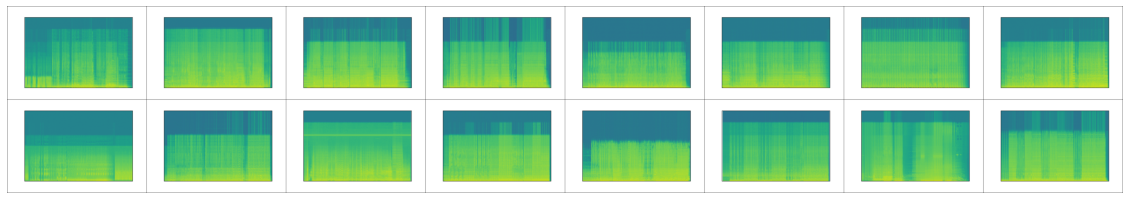

tensor([2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 2])


In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(20, 20))
plt.axis('off')
imshow(torchvision.utils.make_grid(images))
print(labels)

In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 197 * 297, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features


# model = Net()


class Flatten(nn.Module):
    def forward(self, x):
#         print(x.shape)
        return x.view(x.size(0), -1)


model = nn.Sequential(
    nn.Conv2d(3, 8, 5),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, 5),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 5),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2, 2),
    Flatten(),
    nn.Linear(64 * 46 * 71, 1000),
    nn.ReLU(),
    nn.Linear(1000, 4)
)

model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten()
  (9): Linear(in_features=209024, out_features=1000, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1000, out_features=4, bias=True)
)

In [11]:
model.cuda()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten()
  (9): Linear(in_features=102400, out_features=1000, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1000, out_features=2, bias=True)
)

In [20]:
# Randomly initialized model
x = images #.cuda()
out = model(x)
_, pred= torch.max(out, dim=1)
print(f'Pred: {pred}')
print(f'Ground: {labels}')

Pred: tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2])
Ground: tensor([1, 2, 3, 3, 2, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2])


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(5):  # loop models/r the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # update

        # print statistics
        running_loss += loss.item()
        
        
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 1.377
[1,     2] loss: 1.247
[1,     3] loss: 1.450
[1,     4] loss: 1.264
[1,     5] loss: 1.360
[1,     6] loss: 1.401
[1,     7] loss: 1.542
[1,     8] loss: 1.310
[1,     9] loss: 1.392
[1,    10] loss: 1.336
[1,    11] loss: 1.488
[1,    12] loss: 1.414
[1,    13] loss: 1.368
[1,    14] loss: 1.386
[1,    15] loss: 1.394
[1,    16] loss: 1.374
[1,    17] loss: 1.357
[2,     1] loss: 1.339
[2,     2] loss: 1.326
[2,     3] loss: 1.385
[2,     4] loss: 1.331
[2,     5] loss: 1.336
[2,     6] loss: 1.354
[2,     7] loss: 1.384
[2,     8] loss: 1.340
[2,     9] loss: 1.383
[2,    10] loss: 1.261
[2,    11] loss: 1.623
[2,    12] loss: 1.529
[2,    13] loss: 1.301
[2,    14] loss: 1.263
[2,    15] loss: 1.451
[2,    16] loss: 1.315
[2,    17] loss: 1.218
[3,     1] loss: 1.241
[3,     2] loss: 1.239
[3,     3] loss: 1.397
[3,     4] loss: 1.295
[3,     5] loss: 1.328
[3,     6] loss: 1.358
[3,     7] loss: 1.386
[3,     8] loss: 1.354
[3,     9] loss: 1.374
[3,    10] 

In [8]:
torch.save(model.state_dict(), 'model.0.02.pt')

NameError: name 'model' is not defined

In [13]:
model.load_state_dict(torch.load("model-0.0.2", map_location="cpu"), strict=False)
model.eval()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten()
  (9): Linear(in_features=209024, out_features=1000, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1000, out_features=4, bias=True)
)

In [14]:
dataiter = iter(validloader)
images, labels = dataiter.next()

In [15]:
x = images
out = model(x)
_, pred= torch.max(out, dim=1)
print(f'Pred: {pred}')
print(f'Ground: {labels}')

Pred: tensor([2, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 0, 0, 2, 3, 2])
Ground: tensor([2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 2])
